In [1]:
# Import libraries

import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

from PIL import Image
from matplotlib.patches import Patch, Circle



In [2]:
edge_color = "#30011E"
background_color = "#fafafa"

sns.set_style({
    "font.family": "serif",
    "figure.facecolor": background_color,
    "axes.facecolor": background_color,
})


In [3]:
# Load and prepare geo-data, remove states we don't care about
counties = gpd.read_file("C:/Users/ellio/python/MTHE493-5/data/map_data/tl_2024_us_county/")
counties = counties[~counties.STATEFP.isin(["72", "69", "60", "66", "78"])]
counties = counties.set_index("GEOID")

states = gpd.read_file("C:/Users/ellio/python/MTHE493-5/data/map_data/tl_2024_us_state/")
states = states[~states.STATEFP.isin(["72", "69", "60", "66", "78"])]



In [4]:
def translate_geometries(df, x, y, scale, rotate):
    df.loc[:, "geometry"] = df.geometry.translate(yoff=y, xoff=x)
    center = df.dissolve().centroid.iloc[0]
    df.loc[:, "geometry"] = df.geometry.scale(xfact=scale, yfact=scale, origin=center)
    df.loc[:, "geometry"] = df.geometry.rotate(rotate, origin=center)
    return df

def adjust_maps(df):
    df_main_land = df[~df.STATEFP.isin(["02", "15"])]
    df_alaska = df[df.STATEFP == "02"]
    df_hawaii = df[df.STATEFP == "15"]

    df_alaska = translate_geometries(df_alaska, 1300000, -4900000, 0.5, 32)
    df_hawaii = translate_geometries(df_hawaii, 5400000, -1500000, 1, 24)

    return pd.concat([df_main_land, df_alaska, df_hawaii])

C:\Users\ellio\AppData\Local\Temp\ipykernel_12104\1751283553.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "geometry"] = df.geometry.translate(yoff=y, xoff=x)
C:\Users\ellio\AppData\Local\Temp\ipykernel_12104\1751283553.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "geometry"] = df.geometry.translate(yoff=y, xoff=x)
C:\Users\ellio\AppData\Local\Temp\ipykernel_12104\1751283553.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

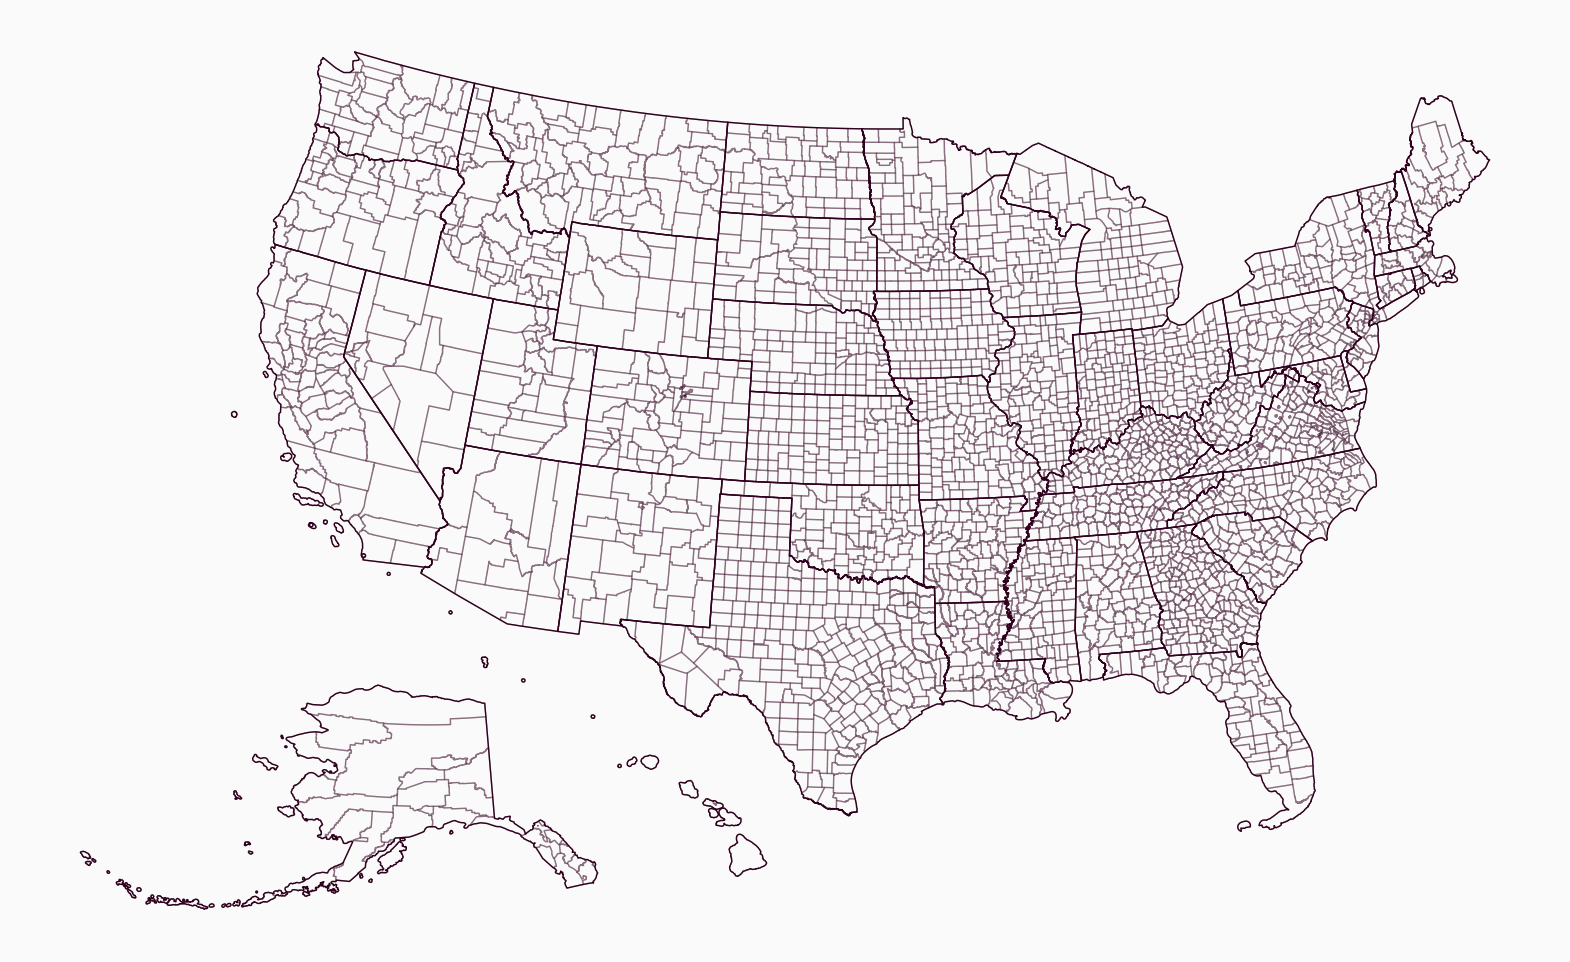

In [5]:
counties = counties.to_crs("ESRI:102003")
states = states.to_crs("ESRI:102003")

counties = adjust_maps(counties)
states = adjust_maps(states)

ax = counties.plot(edgecolor=edge_color + "55", color="None", figsize=(20, 20))
states.plot(ax=ax, edgecolor=edge_color, color="None", linewidth=1)

plt.axis("off")
plt.show()


In [ ]:
#Add data to the map

# Load facebook data
facebook_df = pd.read_csv("C:/Users/ellio/python/MTHE493-5/data/map_data/county_county.tsv", sep="\t")
facebook_df.user_loc = ("0" + facebook_df.user_loc.astype(str)).str[-5:]
facebook_df.fr_loc = ("0" + facebook_df.fr_loc.astype(str)).str[-5:]

# Create data map
county_id = "06075" # San Fransisco
county_name = counties.loc[county_id].NAME
county_facebook_df = facebook_df[facebook_df.user_loc == county_id]

# Create data map
...

selected_color = "#FA26A0"
data_breaks = [
    (90, "#00ffff", "Top 10%"),
    (70, "#00b5ff", "90-70%"),
    (50, "#6784ff", "70-50%"),
    (30, "#aeb3fe", "50-30%"),
    (0, "#e6e5fc", "Bottom 30%"),
]

def create_color(county_df, data_breaks):
    colors = []

    for i, row in county_df.iterrows():
        for p, c, _ in data_breaks:
            if row.value >= np.percentile(county_df.value, p):
                colors.append(c)
                break

    return colors

In [28]:
##Add Annotations to the map 

def add_title(county_id, county_name):
    plt.annotate(
        text="Social Connectedness Ranking Between US Counties and",
        xy=(0.5, 1.1), xycoords="axes fraction", fontsize=16, ha="center"
    )

    plt.annotate(
        text="{} (FIPS Code {})".format(county_name, county_id), 
        xy=(0.5, 1.03), xycoords="axes fraction", fontsize=32, ha="center",
        fontweight="bold"
    )

def add_legend(data_breaks, selected_color, county_name):
    patches = [Patch(facecolor=c, edgecolor=edge_color, label=t) for _, c, t in data_breaks]
    patches = [Patch(facecolor=selected_color, edgecolor=edge_color, label=county_name)] + patches

    leg = plt.legend(
        handles=patches,
        bbox_to_anchor=(0.5, -0.03), loc='center',
        ncol=10, fontsize=20, columnspacing=1,
        handlelength=1, handleheight=1,
        edgecolor=background_color,
        handletextpad=0.4
    )

def add_information():
    plt.annotate(
        "The Facebook Connectivity Index measure the likelyhood that users in different\nlocations are connected on Facebook. The formula divides the number of Facebook\nconnections with the number of possible connections for the two locations.",
        xy=(0.5, -0.08), xycoords="axes fraction", ha="center", va="top", fontsize=18, linespacing=1.8
    )

    plt.annotate(
        "Source: https://dataforgood.facebook.com/", 
        xy=(0.5, -0.22), xycoords="axes fraction", fontsize=16, ha="center",
        fontweight="bold"
    )

def add_circle(ax, counties_df, county_id):
    center = counties_df[counties_df.index == county_id].geometry.centroid.iloc[0]
    ax.add_artist(
        Circle(
            radius=100000, xy=(center.x, center.y), facecolor="None", edgecolor=selected_color, linewidth=4
        )
    )






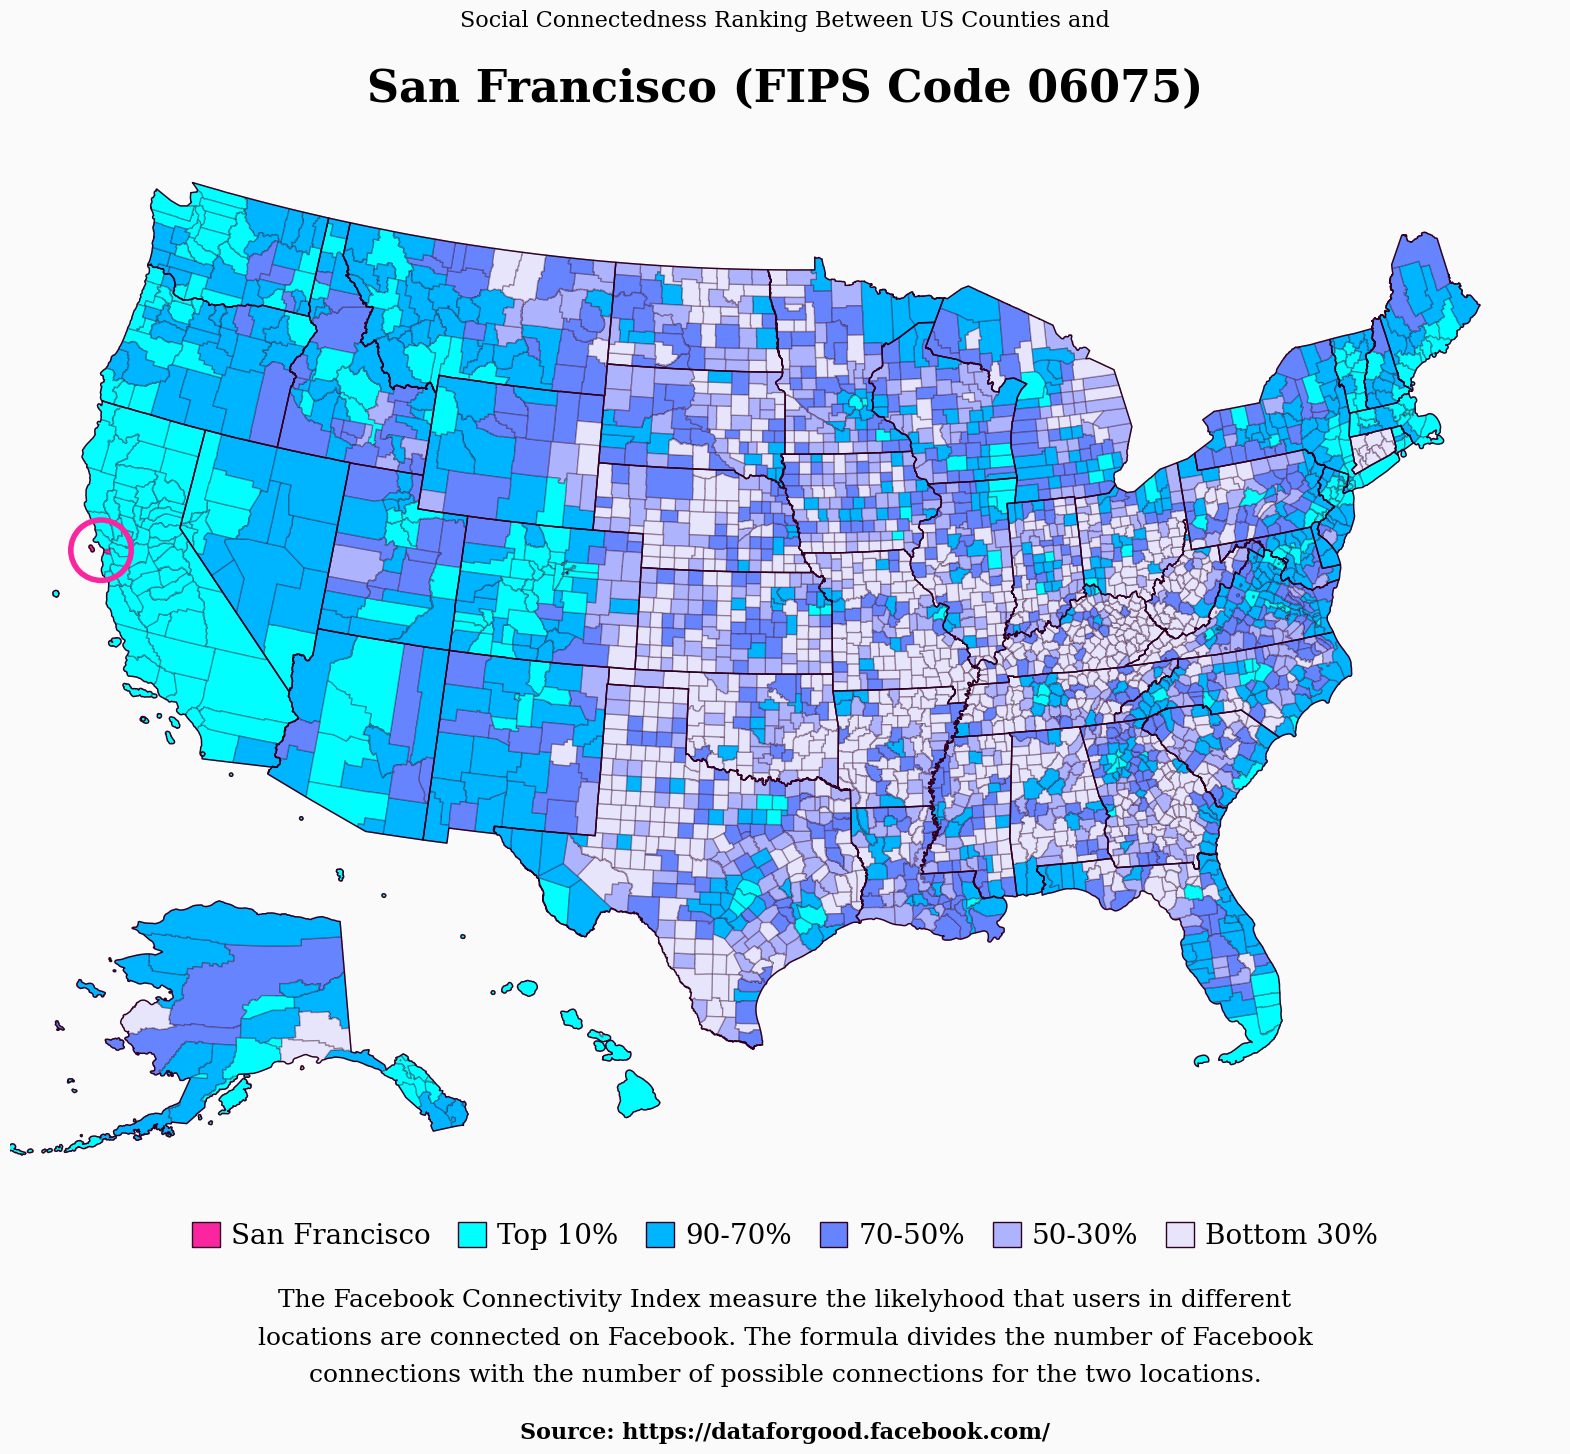

In [ ]:
# Create data map
counties.loc[:, "value"] = (county_facebook_df.set_index("fr_loc").scaled_sci)
counties.loc[:, "value"] = counties["value"].fillna(0)
counties.loc[:, "color"] = create_color(counties, data_breaks)
counties.loc[county_id, "color"] = selected_color

ax = counties.plot(edgecolor=edge_color + "55", color=counties.color, figsize=(20, 20))
states.plot(ax=ax, edgecolor=edge_color, color="None", linewidth=1)
ax.set(xlim=(-2600000, None)) # Removing some of the padding to the left
 
add_circle(ax, counties, county_id)
add_title(county_id, county_name)
add_legend(data_breaks, selected_color, county_name)
add_information()

plt.axis("off")
plt.show()

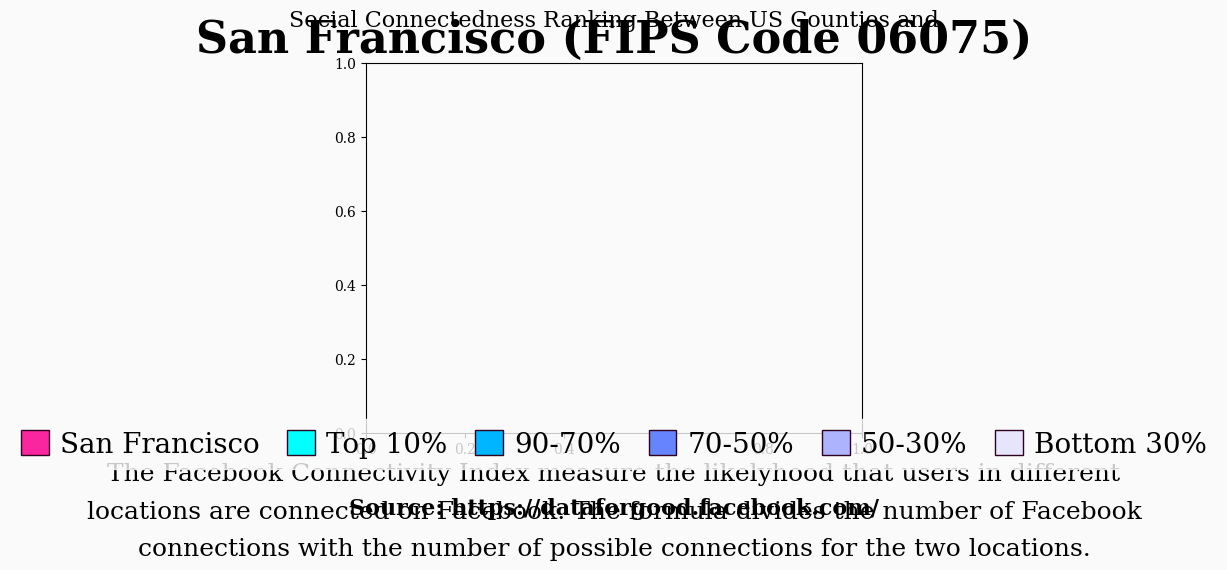

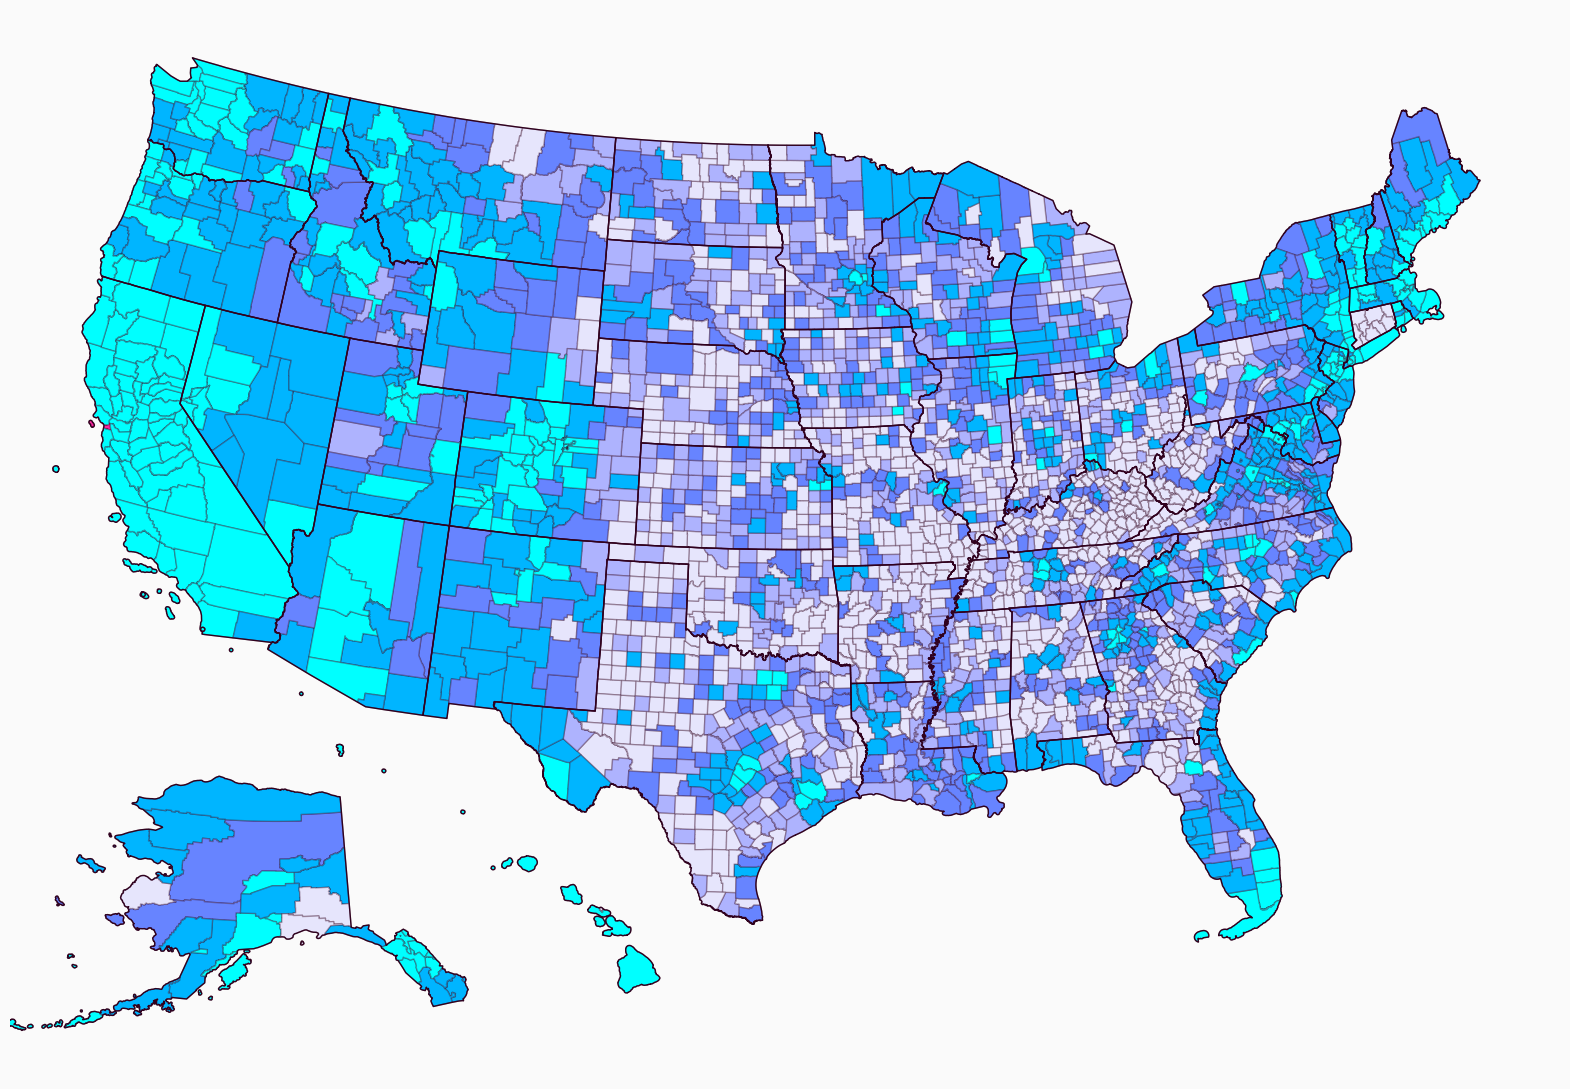

In [27]:
add_circle(ax, counties, county_id)
add_title(county_id, county_name)
add_legend(data_breaks, selected_color, county_name)
add_information()

ax = counties.plot(edgecolor=edge_color + "55", color=counties.color, figsize=(20, 20))
states.plot(ax=ax, edgecolor=edge_color, color="None", linewidth=1)
ax.set(xlim=(-2600000, None)) # Removing some of the padding to the left

plt.axis("off")
plt.show()